<a href="https://colab.research.google.com/github/redman157/HocML/blob/master/Data_analyst_TMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pson2900","key":"2507a7e3dd9a47a3b2ffc26308eaa233"}'}

In [3]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
# List available datasets.
!kaggle datasets list

-rw-r--r-- 1 root root 64 May 14 01:46 kaggle.json
ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          45420  
lava18/google-play-store-apps                                Google Play Store Apps                                2MB  2019-02-03 13:55:47          56795  
karangadiya/fifa19                                           FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59          30018  
jessicali9530/stanford-dogs-dataset                          Stanford Dogs Dataset                               735MB  2019-02-13 05:45:25           3913  
russell

In [4]:
!kaggle competitions download -c tmdb-box-office-prediction

  0% 0.00/60.1k [00:00<?, ?B/s]
100% 60.1k/60.1k [00:00<00:00, 57.7MB/s]
 71% 5.00M/7.02M [00:00<00:00, 42.1MB/s]
100% 7.02M/7.02M [00:00<00:00, 44.7MB/s]
 48% 5.00M/10.3M [00:00<00:00, 33.5MB/s]
100% 10.3M/10.3M [00:00<00:00, 50.7MB/s]


In [5]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


# 1. Import Thư Viện

In [137]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
import shap
from catboost import CatBoostRegressor
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

LookupError: ignored

In [0]:
train = pd.read_csv('train.csv')
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

In [0]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
  for columns in dict_columns:
    df[columns] = df[columns].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
  return df

In [0]:
df_train = text_to_dict(train)
df_test = text_to_dict(test)

# DATA ANALYST

## Belongs_to_collection

In [10]:
df_train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [0]:
df_train['collection_name']  = df_train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
df_train['has_collection']  = df_train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

df_test['collection_name']  = df_test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
df_test['has_collection']  = df_test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

df_train = train.drop(['belongs_to_collection'], axis=1)
df_test = test.drop(['belongs_to_collection'], axis=1)

## Genres

In [12]:
df_train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

In [0]:
list_of_genres_tr = list(df_train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_of_genres_ts = list(df_test['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
df_train['all_genres'] = df_train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values
df_test['all_genres'] = df_test['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values

In [0]:
train = ([i for j in list_of_genres_tr for i in j])
test = ([i for j in list_of_genres_ts for i in j])
from collections import Counter
count_tr = Counter()
count_ts = Counter()
for word in train:
  count_tr[word] += 1
for word in test:
  count_ts[word] += 1

In [0]:
df = pd.DataFrame.from_dict(count_tr , orient='index', columns=['Count'])

In [0]:
df = df.sort_values(by = 'Count', ascending = False)

Text(0.5, 1.0, 'Genres of Peopel')

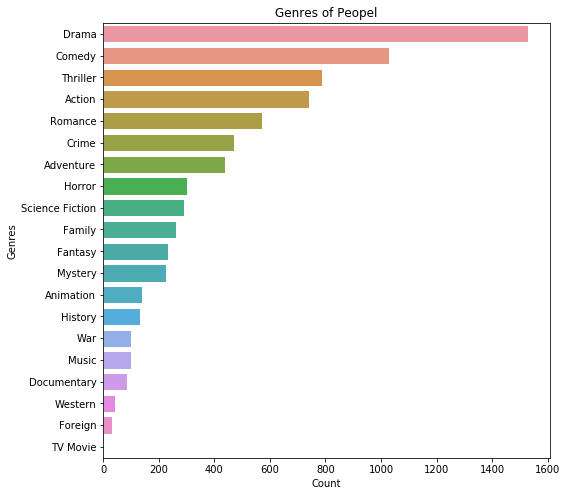

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
sns.set_style("whitegrid")
ax = sns.barplot(x = df['Count'], y =   df.index, data = df)
ax.set(xlabel='Count',ylabel='Genres')
ax.set_title('Genres of Peopel')

In [0]:
df_train['num_genres'] = df_train['genres'].apply(lambda x: len(x) if x != {} else 0)
df_test['num_genres'] = df_test['genres'].apply(lambda x: len(x) if x != {} else 0)

In [0]:
df_train = df_train.drop('genres',axis = 1)
df_test = df_test.drop('genres',axis = 1)

## Production_companies

In [20]:
print('Number of production companies in films')
df_train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production companies in films


1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

In [0]:
list_of_companies = list(df_train['production_companies'].apply(lambda x : [i['name'] for i in x] if x != {} else []).values)

In [0]:
from collections import Counter
count_name = Counter()
for name in list_of_companies:
  for item in name:
    count_name[item] += 1
#Counter([item for name in list_of_companies for item in name])

In [23]:
count_name.most_common(30)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30),
 ('Fox Searchlight Pictures', 29),
 ('StudioCanal', 28),
 ('Lionsgate', 28),
 ('DreamWorks SKG', 27),
 ('Fox 2000 Pictures', 25),
 ('Summit Entertainment', 24),
 ('Hollywood Pictures', 24),
 ('Orion Pictures', 24),
 ('Amblin Entertainment', 23),
 ('Dimension Films', 23)]

In [0]:
df_train['num_companies'] = df_train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
df_train['all_production_companies'] = df_train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
   df_train['production_company_' + g] = df_train['all_production_companies'].apply(lambda x: 1 if g in x else 0)

df_test['num_companies'] = df_test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
df_test['all_production_companies'] = df_test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    df_test['production_company_' + g] = df_test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

df_train = df_train.drop(['production_companies', 'all_production_companies'], axis=1)
df_test = df_test.drop(['production_companies', 'all_production_companies'], axis=1)

## production_countries

In [25]:
for index, value in enumerate(df_train['production_countries'][:5]):
  print(index, value)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [26]:
df_train['production_countries'].apply(lambda x : len(x) if x != {} else 0).value_counts()

1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

In [0]:
list_of_countries = list(df_train['production_countries'].apply(lambda x : [i['name'] for i in x] if x!= {} else []).values)

In [0]:
a = Counter(item for name in list_of_countries for item in name).most_common(30)

In [0]:
df_train['num_countries'] = df_train['production_countries'].apply(lambda x : len(x) if x != {} else 0)
df_train['all_countries'] = df_train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in a]
for g in top_countries:
  df_train['production_country_' + g] = df_train['all_countries'].apply(lambda x: 1 if g in x else 0)
  
df_test['num_countries'] = df_test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
df_test['all_countries'] = df_test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
  df_test['production_country_' + g] = df_test['all_countries'].apply(lambda x: 1 if g in x else 0)

df_train = df_train.drop(['production_countries', 'all_countries'], axis=1)
df_test = df_test.drop(['production_countries', 'all_countries'], axis=1)

## Spoken languages

In [30]:
for index, value in enumerate(df_train['spoken_languages'][:5]):
  print(index,value)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [31]:
df_train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [0]:
list_of_languages = list(df_train['spoken_languages'].apply(lambda x : [i['name'] for i in x ] if x != {} else []).values)

In [37]:
top_language =  Counter(item for name in list_of_languages for item in name).most_common(30)


list

In [0]:
df_train['num_languages'] = df_train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
df_train['all_languages'] = df_train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
  df_train['languages_' + g ] = df_train['all_languages'].apply(lambda x : 1 if g in x  else 0)

df_test['num_languages'] = df_test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
df_test['all_languages'] = df_test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_languages:
  df_test['language_' + g] = df_test['all_languages'].apply(lambda x: 1 if g in x else 0)

df_train = df_train.drop(['spoken_languages', 'all_languages'], axis=1)
df_test = df_test.drop(['spoken_languages', 'all_languages'], axis=1)  

In [0]:
df_train['all_languages']

## Keywords

In [47]:
for index, value in enumerate(df_train['Keywords'][:5]):
  print(index, value)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [48]:
all_of_keywords = []
for line in df_train['Keywords']:
  array = []
  for item in line:
    array.append(item['name'])
  else:
    all_of_keywords.append(array)
else:
  print(all_of_keywords)

[['time travel', 'sequel', 'hot tub', 'duringcreditsstinger'], ['coronation', 'duty', 'marriage', 'falling in love'], ['jazz', 'obsession', 'conservatory', 'music teacher', 'new york city', 'violence', 'montage', 'drummer', 'public humiliation', 'jazz band', 'young adult', 'music school'], ['mystery', 'bollywood', 'police corruption', 'crime', 'india', 'missing husband', 'nerve gas'], [], [], [], ['journalism', 'translation', 'television', 'manipulation of the media', 'iraq', 'reporter', 'woman director'], ['island', 'pirate gang', 'puppet', 'treasure hunt'], ['mockumentary', 'folk singer'], ['underdog', 'philadelphia', 'transporter', 'italo-american', 'fight', "love of one's life", 'publicity', 'boxer', 'independence', 'boxing match', 'training', 'lovers', 'surprise', 'world champion', 'amateur', 'victory'], ['nerd', 'vacation', 'farce', 'jock', 'frame up', 'defector'], ['male nudity', 'female nudity', 'adultery', 'parent child relationship', 'midlife crisis', 'coming out', 'first tim

In [0]:
all_keywords = list(df_train['Keywords'].apply(lambda x : [i['name'] for i in x ]  if x != {} else "0").values)

In [50]:
all_keywords

[['time travel', 'sequel', 'hot tub', 'duringcreditsstinger'],
 ['coronation', 'duty', 'marriage', 'falling in love'],
 ['jazz',
  'obsession',
  'conservatory',
  'music teacher',
  'new york city',
  'violence',
  'montage',
  'drummer',
  'public humiliation',
  'jazz band',
  'young adult',
  'music school'],
 ['mystery',
  'bollywood',
  'police corruption',
  'crime',
  'india',
  'missing husband',
  'nerve gas'],
 '0',
 '0',
 '0',
 ['journalism',
  'translation',
  'television',
  'manipulation of the media',
  'iraq',
  'reporter',
  'woman director'],
 ['island', 'pirate gang', 'puppet', 'treasure hunt'],
 ['mockumentary', 'folk singer'],
 ['underdog',
  'philadelphia',
  'transporter',
  'italo-american',
  'fight',
  "love of one's life",
  'publicity',
  'boxer',
  'independence',
  'boxing match',
  'training',
  'lovers',
  'surprise',
  'world champion',
  'amateur',
  'victory'],
 ['nerd', 'vacation', 'farce', 'jock', 'frame up', 'defector'],
 ['male nudity',
  'female

In [51]:
print('Number of Keywords in films')
df_train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of Keywords in films


5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: Keywords, dtype: int64

In [0]:
from collections import Counter

value = Counter(item for name in all_keywords for item in name).most_common(40)
data = pd.DataFrame(data = value, columns=(['Keywords', 'Count']))
data = data.sort_values(by = "Count", ascending = False)

Text(0.5, 1.0, 'All_Of_Keywords')

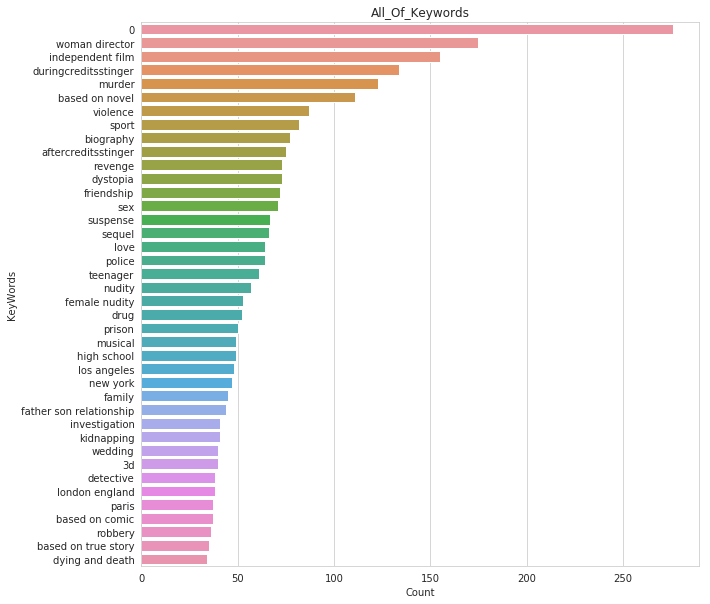

In [53]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.set_style("whitegrid")
ax = sns.barplot(x = data['Count'], y = data['Keywords'], data = data)
ax.set(xlabel='Count',ylabel='KeyWords')
ax.set_title('All_Of_Keywords')

In [0]:
df_train['num_keywords']  =  df_train['Keywords'].apply(lambda x : len(x) if x != {} else 0)
df_train['all_Keywords']  =  df_train['Keywords'].apply(lambda x : [i['name'] for i in x] if x != {} else '')
top_keywords = [m[0] for m in Counter(item for name in all_keywords for item in name).most_common(40)]
for g in top_keywords:
  df_train['Keywords_' + g] = df_train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
  
df_test['num_keywords']  =  df_test['Keywords'].apply(lambda x : len(x) if x != {} else 0)
df_test['all_Keywords']  =  df_test['Keywords'].apply(lambda x : [i['name'] for i in x] if x != {} else '')
for g in top_keywords:
  df_test['Keywords_' + g] = df_test['all_Keywords'].apply(lambda x: 1 if g in x else 0)  

df_train = df_train.drop(['Keywords', 'all_Keywords'], axis=1)
df_test = df_test.drop(['Keywords', 'all_Keywords'], axis=1)

## Cast:

In [58]:
for index , value in enumerate(df_train['cast'][:1]):
  print(index, value)


0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [59]:
df_train['cast'][0]

[{'cast_id': 4,
  'character': 'Lou',
  'credit_id': '52fe4ee7c3a36847f82afae7',
  'gender': 2,
  'id': 52997,
  'name': 'Rob Corddry',
  'order': 0,
  'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'},
 {'cast_id': 5,
  'character': 'Nick',
  'credit_id': '52fe4ee7c3a36847f82afaeb',
  'gender': 2,
  'id': 64342,
  'name': 'Craig Robinson',
  'order': 1,
  'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'},
 {'cast_id': 6,
  'character': 'Jacob',
  'credit_id': '52fe4ee7c3a36847f82afaef',
  'gender': 2,
  'id': 54729,
  'name': 'Clark Duke',
  'order': 2,
  'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'},
 {'cast_id': 7,
  'character': 'Adam Jr.',
  'credit_id': '52fe4ee7c3a36847f82afaf3',
  'gender': 2,
  'id': 36801,
  'name': 'Adam Scott',
  'order': 3,
  'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'},
 {'cast_id': 8,
  'character': 'Hot Tub Repairman',
  'credit_id': '52fe4ee7c3a36847f82afaf7',
  'gender': 2,
  'id': 54812,
  'name': 'Chevy Chase',
  'order': 4,
  'prof

In [60]:
print('Number of casted persons in films')
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


TypeError: ignored

In [0]:
list_of_cast_name = list(df_train['cast'].apply(lambda x : [i['name'] for i in x]  if x != {} else []).values)
top_name = Counter([name for names in list_of_cast_name for name in names])

In [0]:
top = top_name.most_common(15)

In [0]:
from PIL import Image
from urllib.request import urlopen
import cv2
from collections import Counter

In [62]:
list_of_cast_nameurl = list(train['cast'].apply(lambda x: [(i['name'], i['profile_path']) for i in x] if x != {} else []).values)
c = Counter([i for j in list_of_cast_nameurl for i in j]).most_common(16)
fig = plt.figure(figsize=(20,16))
for name, pic in enumerate([name[0] for name in c ]):
  ax = fig.add_subplot(4, 4, name+1, xticks=[], yticks=[])
  img = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{pic[1]}"))
  plt.imshow(img)
  ax.set_title(f'{pic[0]}')

TypeError: ignored

In [0]:
list_of_all_gender = list(df_train['cast'].apply(lambda x : [i['gender'] for i in x] if x != {} else []).values)
count_gender = Counter([i for gender in list_of_all_gender for i in gender]).most_common

In [0]:
list_of_cast_characters = list(df_train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
count_charac = Counter([i for j in list_of_cast_characters for i in j]).most_common(15)

In [64]:
df_train['num_cast'] = df_train['cast'].apply(lambda x : len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_name for i in j]).most_common(15)]
for item in top_cast_names:
  df_train['cast_name ' + item]=  df_train['cast'].apply(lambda x : 1 if item in str(x) else 0 )
df_train['cast_0_gender'] = df_train['cast'].apply(lambda x : sum([1 for i in x if i['gender'] == 0]))
df_train['cast_1_gender'] = df_train['cast'].apply(lambda x : sum([1 for i in x if i['gender'] == 1]))
df_train['cast_2_gender'] = df_train['cast'].apply(lambda x : sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
  df_train['cast_character_' + g] = df_train['cast'].apply(lambda x: 1 if g in str(x) else 0)

df_test['num_cast'] = df_test['cast'].apply(lambda x : len(x) if x != {} else 0)
for item in top_cast_names:
  df_test['cast_name ' + item]=  df_test['cast'].apply(lambda x : 1 if item in str(x) else 0 )
df_test['cast_0_gender'] = df_test['cast'].apply(lambda x : sum([1 for i in x if i['gender'] == 0]))
df_test['cast_1_gender'] = df_test['cast'].apply(lambda x : sum([1 for i in x if i['gender'] == 1]))
df_test['cast_2_gender'] = df_test['cast'].apply(lambda x : sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
  df_test['cast_character_' + g] = df_test['cast'].apply(lambda x: 1 if g in str(x) else 0)

df_train = df_train.drop(['cast'], axis=1)
df_test = df_test.drop(['cast'], axis=1)

NameError: ignored

## Crew

In [65]:
for index , value in enumerate(df_train['crew'][:1]):
  print(index,value)

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In [66]:
value[:3]

[{'credit_id': '59ac067c92514107af02c8c8',
  'department': 'Directing',
  'gender': 0,
  'id': 1449071,
  'job': 'First Assistant Director',
  'name': 'Kelly Cantley',
  'profile_path': None},
 {'credit_id': '52fe4ee7c3a36847f82afad7',
  'department': 'Directing',
  'gender': 2,
  'id': 3227,
  'job': 'Director',
  'name': 'Steve Pink',
  'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'},
 {'credit_id': '5524ed25c3a3687ded000d88',
  'department': 'Writing',
  'gender': 2,
  'id': 347335,
  'job': 'Writer',
  'name': 'Josh Heald',
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}]

In [0]:
list_of_crew_gender = list(df_train['crew'].apply(lambda x : [i['gender'] for i in x] if x != {} else []).values)
list_of_crew_department = list(df_train['crew'].apply(lambda x : [i['department'] for i in x] if x != {} else []).values)
list_of_crew_name = list(df_train['crew'].apply(lambda x : [i['name'] for i in x] if x != {} else []).values)
list_of_crew_job = list(df_train['crew'].apply(lambda x : [i['job'] for i in x] if x != {} else []).values)

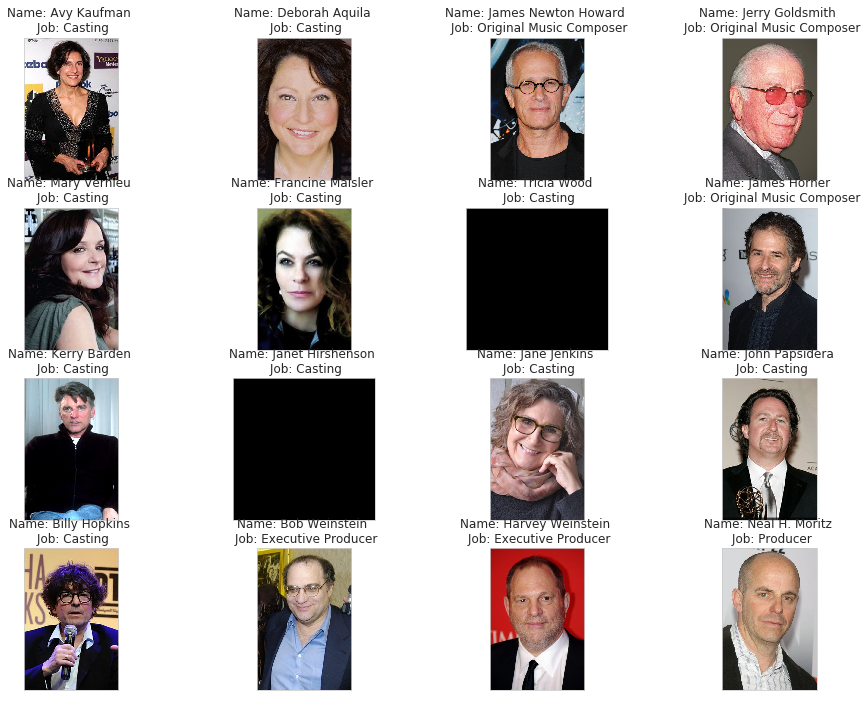

In [68]:
top_name_crew =  Counter([i for line in list_of_crew_name for i in line]).most_common(16)
name_and_url = list(df_train['crew'].apply(lambda x : [(i['name'],i['job'],i['profile_path']) for i in x] if x != {} else []).values)
count_crew =  Counter([i for j in name_and_url for i in j]).most_common(16)
fig = plt.figure(figsize=(16,12))
for name, pic in enumerate([m[0] for m in count_crew]):
  ax = fig.add_subplot(4,4 , name + 1 , xticks=[], yticks=[])
  if pic[2]:
    img = Image.open(urlopen(f'https://image.tmdb.org/t/p/w600_and_h900_bestv2{pic[2]}'))
  else:
    img = Image.new("RGB", (5,5))
  plt.imshow(img)
  ax.set_title(f'Name: {pic[0]} \n Job: {pic[1]}')
  

In [0]:
df_train['num_crew'] = df_train['crew'].apply(lambda x : len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_name for i in j]).most_common(15)]
for g in top_crew_names:
  df_train['crew_name' + g ] = df_train['crew'].apply(lambda x : 1 if g in str(x) else 0)
df_train['genders_0_crew'] = df_train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
df_train['genders_1_crew'] = df_train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
df_train['genders_2_crew'] = df_train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_job for i in j]).most_common(15)]
for j in top_crew_jobs:
  df_train['jobs_' + j] = df_train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))

top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_department for i in j]).most_common(15)]
for j in top_crew_departments:
  df_train['departments_' + j] = df_train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
   

In [0]:
df_test['num_crew'] = df_test['crew'].apply(lambda x : len(x) if x != {} else 0)
for g in top_crew_names:
  df_test['crew_name' + g ] = df_test['crew'].apply(lambda x : 1 if g in str(x) else 0)
df_test['genders_0_crew'] = df_test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
df_test['genders_1_crew'] = df_test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
df_test['genders_2_crew'] = df_test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

for j in top_crew_jobs:
  df_test['jobs_' + j] = df_test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))

top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_department for i in j]).most_common(15)]
for j in top_crew_departments:
  df_test['departments_' + j] = df_test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
  

In [0]:
df_train = df_train.drop(['crew'], axis=1)
df_test = df_test.drop(['crew'], axis=1)

# Data exploration and Data visualization

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Target

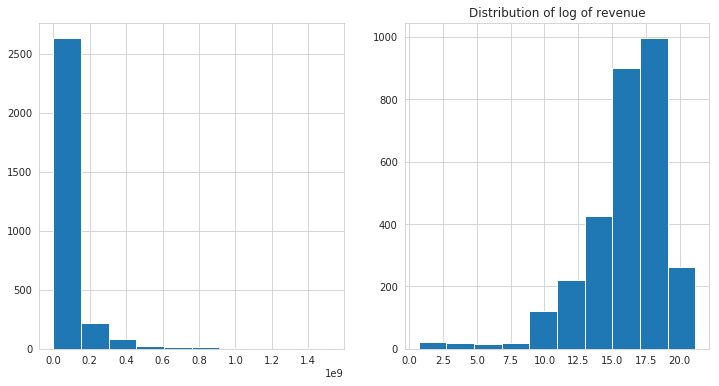

In [84]:
fig , ax = plt.subplots(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(df_train['revenue'])

plt.subplot(1,2,2)
plt.hist(np.log1p(df_train['revenue']))

plt.title('Distribution of log of revenue');

In [86]:
df_train['log_revenue'] = np.log1p(df_train['revenue'])

0    16.326300
1    18.370959
2    16.387512
3    16.588099
4    15.182615
5    14.997740
6    18.263396
7    14.765821
8    17.351454
9    16.746717
Name: log_revenue, dtype: float64

### Budget

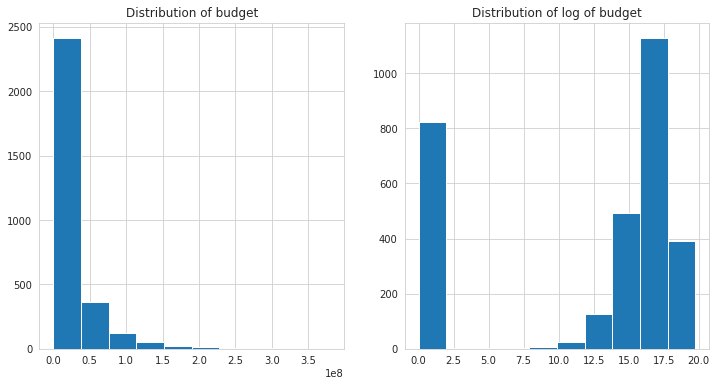

In [95]:
fig, ax = plt.subplots(figsize= ( 12,6))
plt.subplot(1,2,1)
plt.hist(df_train['budget'])
plt.title('Distribution of budget');

plt.subplot(1,2,2)
plt.hist(np.log1p(df_train['budget']))
plt.title('Distribution of log of budget');

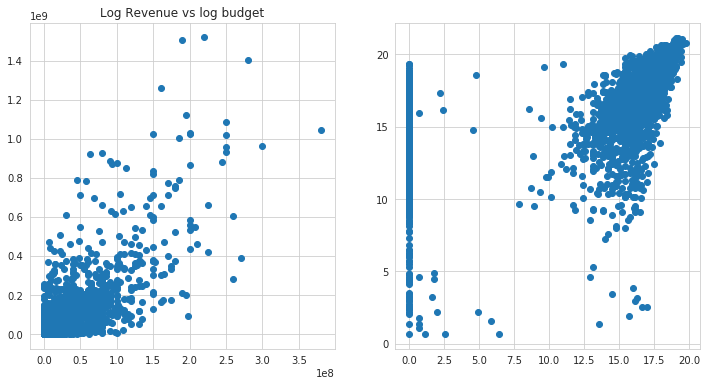

In [99]:
fig , ax = plt.subplots(figsize= (12,6))
plt.title('Revenue vs budget');
plt.subplot(1,2,1)
plt.scatter(df_train['budget'], df_train['revenue'])

plt.title('Log Revenue vs log budget');
plt.subplot(1,2,2)
plt.scatter(np.log1p(df_train['budget']) , np.log1p(df_train['revenue']))

In [0]:
df_train['log_budget'] = np.log1p(df_train['budget'])
df_test['log_budget'] = np.log1p(df_test['budget'])

### Homepage

In [102]:
df_train['homepage'].value_counts().head()

http://www.transformersmovie.com/                 4
http://www.thehobbit.com/                         2
http://www.lordoftherings.net/                    2
http://www.polisse-lefilm.com/                    1
http://disney.go.com/disneynature/africancats/    1
Name: homepage, dtype: int64

In [0]:
df_train['has_homepage'] = 0
df_train.loc[df_train['homepage'].isnull() == False, 'has_homepage'] = 1
df_test['has_homepage'] = 0
df_test.loc[df_test['homepage'].isnull() == False, 'has_homepage'] = 1

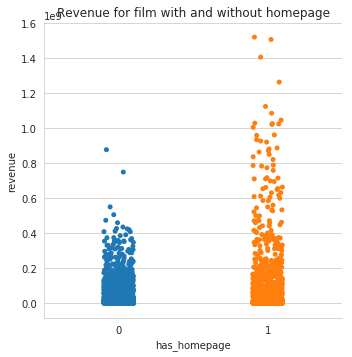

In [106]:
sns.catplot(x='has_homepage', y='revenue', data=df_train);
plt.title('Revenue for film with and without homepage');

### original_language

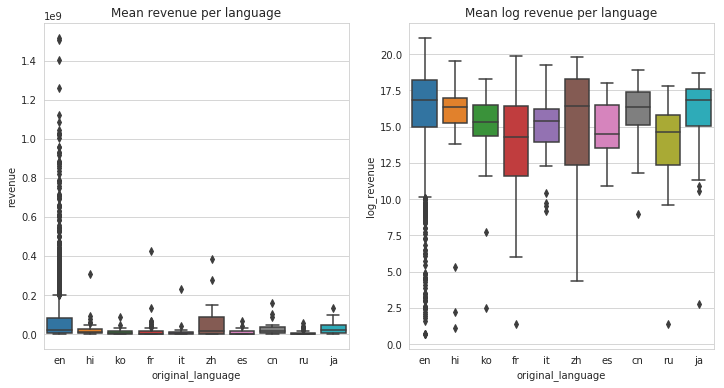

In [112]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.boxplot(x='original_language',y= 'revenue' , data = df_train.loc[
    df_train['original_language'].isin(
        df_train['original_language'].value_counts().head(10).index)])
plt.title('Mean revenue per language');

plt.subplot(1,2,2)
sns.boxplot(x='original_language', y='log_revenue', data=df_train.loc[
    df_train['original_language'].isin(
        df_train['original_language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

### original_title

In [113]:
df_train['original_title'].head(10)

0                      Hot Tub Time Machine 2
1    The Princess Diaries 2: Royal Engagement
2                                    Whiplash
3                                     Kahaani
4                                        마린보이
5      Pinocchio and the Emperor of the Night
6                              The Possession
7                                Control Room
8                      Muppet Treasure Island
9                               A Mighty Wind
Name: original_title, dtype: object

In [0]:
list_of_title = list(df_train['original_title'].apply(lambda x : x).values)
count_title = Counter([value for value in text]).most_common()
df_ = pd.DataFrame(data = count_title, columns=(['Value','Count']))


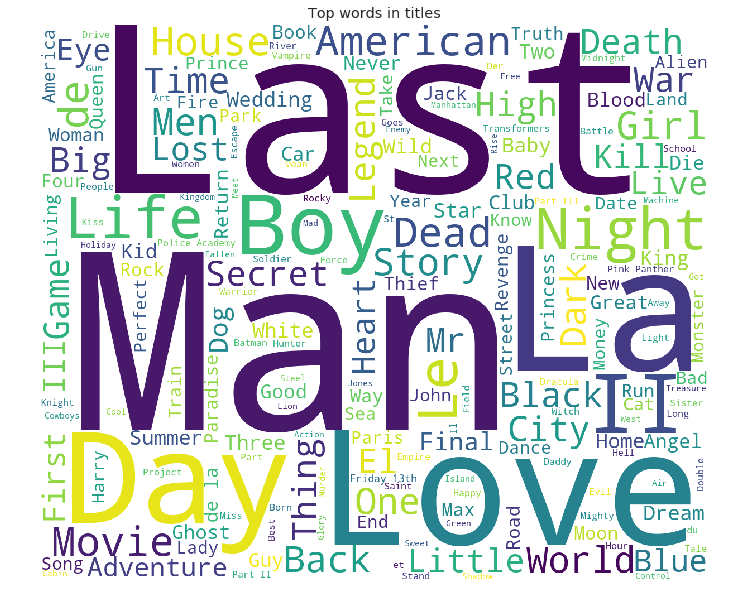

In [160]:
plt.figure(figsize= (12,12))
text = ' '.join(df_train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

In [0]:
a = text.split(" ")
count  =  Counter([i for i in a ]).most_common(30)

In [0]:
df_  = pd.DataFrame(data = count, columns=(['value','count']))

Text(0.5, 1.0, 'Top Words of Title')

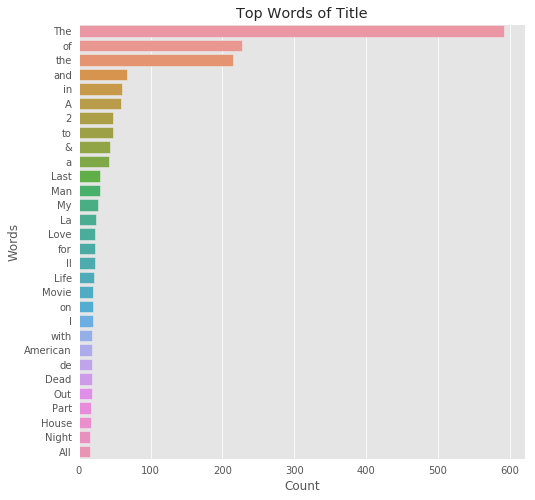

In [183]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
ax = sns.barplot(x = df_['count'], y = df_['value'], data = df_)
ax.set(xlabel='Count',ylabel='Words')
ax.set_title('Top Words of Title')

### overview

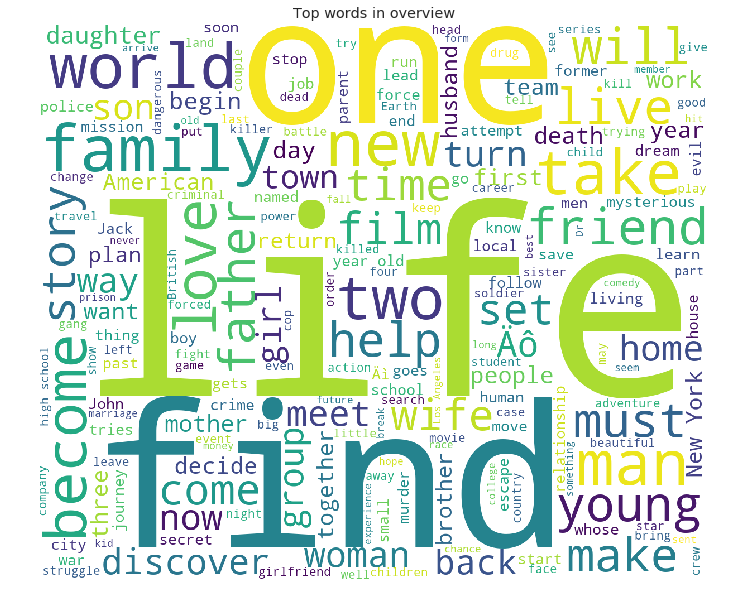

In [185]:
plt.figure(figsize= (12,12))
text = ''.join(df_train['overview'].fillna('').values)
wordcould = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcould)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

In [0]:
vector = TfidfVectorizer(sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5)

overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')